<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Var" data-toc-modified-id="Var-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Var</a></span></li><li><span><a href="#Init" data-toc-modified-id="Init-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Init</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load</a></span><ul class="toc-item"><li><span><a href="#Format" data-toc-modified-id="Format-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Format</a></span></li><li><span><a href="#Filtering" data-toc-modified-id="Filtering-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Filtering</a></span></li></ul></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plotting</a></span></li><li><span><a href="#Tree-subsample" data-toc-modified-id="Tree-subsample-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Tree subsample</a></span></li><li><span><a href="#RRPP" data-toc-modified-id="RRPP-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>RRPP</a></span><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Summary</a></span></li></ul></li><li><span><a href="#RRPP:-no-phy-cov" data-toc-modified-id="RRPP:-no-phy-cov-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>RRPP: no phy-cov</a></span><ul class="toc-item"><li><span><a href="#RRPP" data-toc-modified-id="RRPP-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>RRPP</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Summary</a></span></li></ul></li><li><span><a href="#sessionInfo" data-toc-modified-id="sessionInfo-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>sessionInfo</a></span></li></ul></div>

# Goal

* RRPP analysis to assess correlations of OTUs and host phenotypes while controlling for host phylogeny
* Just assessing Methanobrevibacter ASVs versus body temperature

# Var

In [1]:
work_dir = '/ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/modulating/RRPP/'

# microbiome
## 16S-arch phyloseq object (one sample per individual)
physeq_arch_IndD_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/merged/phyloseq/physeq_arch_IndD_rare250.RDS'

# host tree
host_tree_IndD_file = '/ebio/abt3_projects/Georg_animal_feces/data/animal/phylogeny/TT/unified_metadata_complete_200429_16S-arch_IndD.nwk'

# body temp data
Tb_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/merged//bodyTemp_all.tsv'

# misc params
threads = 12
my_seed = 8394

# Init

In [2]:
library(dplyr)
library(tidyr)
library(ggplot2)

library(ape)
library(phyloseq)
library(RRPP)

library(doParallel)
library(LeyLabRMisc)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘RRPP’


The following object is masked from ‘package:phyloseq’:

    ordinate


Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



In [3]:
# cluster job submission
#clustermq_setup()
#library(clustermq)

In [4]:
df.dims()
set.seed(my_seed)
make_dir(work_dir)
RhpcBLASctl::blas_set_num_threads(1)

Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/modulating/RRPP/ 


# Load

In [5]:
# phyloseq obj.
physeq = readRDS(physeq_arch_IndD_file) %>%
    subset_taxa(Order == 'Methanobacteriales') %>%
    subset_taxa(Genus != 'unclassified') %>%
    filter_taxa(function(x) sum(x > 0) >= 2, TRUE) %>%
    prune_samples(sample_sums(.) > 0, .) 
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 183 taxa and 179 samples ]
sample_data() Sample Data:       [ 179 samples by 88 sample variables ]
tax_table()   Taxonomy Table:    [ 183 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 183 tips and 182 internal nodes ]

In [6]:
# otu table
otu = physeq %>%
    phyloseq2df(otu_table) %>%
    as.data.frame
rownames(otu) = otu$OTU
otu$OTU = NULL
otu = otu %>% t %>% as.data.frame
colnames(otu) = gsub('^([0-9])', 'X_\\1', colnames(otu))
otu

,b9654a42cc8eefb1cbb0daba005335ff,X_5cd4fe5cb79cdf4841549e580ea5a27f,dfe0fdab42ac9381d9732fff3f8cbf3c,X_9f56339e83804b62fd2e269181961eff,X_9c1e5bb65fd0239bde43b74d3dc76e5c,bb1ddb99134c94c9c3835e0f7d935b5d,da56441392b5139cad3ce36e332959b9,X_387e1c6af988725eba3004894f1a3626,d7b6b92effb83779f2786dd06fb20ed6,X_6ae206e3a0b694df124483499a431f39,⋯,X_95cfc3c342d1f3a2af58c49f6065b08a,f40a4552f05b5c3ca111c9886b7360a0,e50dfa4783c02bc4cbff9d9297e8d844,X_056a6332380b1f40d814d70adc074217,de8bd36d71e9372a6b9e16b54cefa562,X_569a2abee10cb7fdef315334d856b92b,X_890c6bb9fc8dea9dc4b756a645f4f472,b171d5cdecd235e7199d44ce8991794d,X_36fd5c55ad082f4d05194157da9d13da,d7dd0bdd8184f8cb7189e1e09afa97d0
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F14_Common_Bream,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0.0
F35_Red_Deer,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,3.6
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
X405_Nile_Crocodile,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
X67_European_Roe,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [7]:
# host phylogeny
host_tree = read.tree(host_tree_IndD_file)
host_tree


Phylogenetic tree with 185 tips and 184 internal nodes.

Tip labels:
	X60_European_Chub, X179_Roach, X330_Ide, X327_Silver_Bream, X326_Silver_Bream, F14_Common_Bream, ...
Node labels:
	, @_20_@, @_17_@, @_14_@, @_9_@, @_15_@, ...

Rooted; includes branch lengths.

In [8]:
# metadata
metadata = physeq %>% 
    phyloseq2df(sample_data) %>%
    mutate(scientific_name = gsub(' ', '_', scientific_name),
           digestive_system = gsub('fermentation activity ', '', digestive_system),
           dig_sys = gsub('simple ', '', digestive_system)) %>%
    as.data.frame
rownames(metadata) = metadata$SampleID
metadata 

,SampleID,host_subject_id,host_german_name,host_common_name,scientific_name,scientific_name_subspecies,host_taxid,class,order,family,⋯,i.CH4_L.d_mean,i.CH4_L.d_sd,i.CH4_L.kgBM_mean,i.CH4_L.kgBM_sd,i.CH4_g.d_mean,i.CH4_g.d_sd,i.CH4_kJ.d_mean,i.CH4_kJ.d_sd,Sample,dig_sys
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
F14_Common_Bream,F14_Common_Bream,F14,Brachse,Common.Bream,Abramis_brama,NA,38527,Actinopterygii,Cypriniformes,Cyprinidae,⋯,NA,NA,NA,NA,NA,NA,NA,NA,F14_Common_Bream,simple
F35_Red_Deer,F35_Red_Deer,F35,Rothirsch,Red.Deer,Cervus_elaphus,NA,9860,Mammalia,Artiodactyla,Cervidae,⋯,52.24132,27.18306,0.4858472,0.1686955,38.67117,21.30162,2066.942,1075.505,F35_Red_Deer,foregut
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
X405_Nile_Crocodile,X405_Nile_Crocodile,405,Nilkrokodil,Nile.Crocodile,Crocodylus_niloticus,NA,8501,Reptilia,Crocodilia,Crocodylidae,⋯,NA,NA,NA,NA,NA,NA,NA,NA,X405_Nile_Crocodile,simple
X67_European_Roe,X67_European_Roe,67,Reh,European.Roe,Capreolus_capreolus,NA,9858,Mammalia,Artiodactyla,Cervidae,⋯,NA,NA,NA,NA,NA,NA,NA,NA,X67_European_Roe,foregut


In [9]:
# adding body temp
metadata = metadata %>%
    inner_join(read.delim(Tb_file) %>% 
                   dplyr::select(scientific_name, dataset, Tb) %>%
                   mutate(scientific_name = gsub(' ', '_', scientific_name)),
               c('scientific_name')) %>%
    rename('dataset_Tb' = dataset)

metadata %>% .$Tb %>% summary_x
metadata 

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,NA's,sd,sd_err_of_mean
.,30.7,37.4,38.6,38.27883,39.5,41.9,42,3.802,1.437


SampleID,host_subject_id,host_german_name,host_common_name,scientific_name,scientific_name_subspecies,host_taxid,class,order,family,⋯,i.CH4_L.kgBM_mean,i.CH4_L.kgBM_sd,i.CH4_g.d_mean,i.CH4_g.d_sd,i.CH4_kJ.d_mean,i.CH4_kJ.d_sd,Sample,dig_sys,dataset_Tb,Tb
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
F14_Common_Bream,F14,Brachse,Common.Bream,Abramis_brama,NA,38527,Actinopterygii,Cypriniformes,Cyprinidae,⋯,NA,NA,NA,NA,NA,NA,F14_Common_Bream,simple,NA,NA
F35_Red_Deer,F35,Rothirsch,Red.Deer,Cervus_elaphus,NA,9860,Mammalia,Artiodactyla,Cervidae,⋯,0.4858472,0.1686955,38.67117,21.30162,2066.942,1075.505,F35_Red_Deer,foregut,WalzerXXXX,38.6
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
X405_Nile_Crocodile,405,Nilkrokodil,Nile.Crocodile,Crocodylus_niloticus,NA,8501,Reptilia,Crocodilia,Crocodylidae,⋯,NA,NA,NA,NA,NA,NA,X405_Nile_Crocodile,simple,NA,NA
X67_European_Roe,67,Reh,European.Roe,Capreolus_capreolus,NA,9858,Mammalia,Artiodactyla,Cervidae,⋯,NA,NA,NA,NA,NA,NA,X67_European_Roe,foregut,WalzerXXXX,40.4


## Format

In [10]:
vars = c('Tb')
otu = cbind(metadata[,vars, drop=FALSE], otu)
otu

,Tb,b9654a42cc8eefb1cbb0daba005335ff,X_5cd4fe5cb79cdf4841549e580ea5a27f,dfe0fdab42ac9381d9732fff3f8cbf3c,X_9f56339e83804b62fd2e269181961eff,X_9c1e5bb65fd0239bde43b74d3dc76e5c,bb1ddb99134c94c9c3835e0f7d935b5d,da56441392b5139cad3ce36e332959b9,X_387e1c6af988725eba3004894f1a3626,d7b6b92effb83779f2786dd06fb20ed6,⋯,X_95cfc3c342d1f3a2af58c49f6065b08a,f40a4552f05b5c3ca111c9886b7360a0,e50dfa4783c02bc4cbff9d9297e8d844,X_056a6332380b1f40d814d70adc074217,de8bd36d71e9372a6b9e16b54cefa562,X_569a2abee10cb7fdef315334d856b92b,X_890c6bb9fc8dea9dc4b756a645f4f472,b171d5cdecd235e7199d44ce8991794d,X_36fd5c55ad082f4d05194157da9d13da,d7dd0bdd8184f8cb7189e1e09afa97d0
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F14_Common_Bream,NA,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0.0
F35_Red_Deer,38.6,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,3.6
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
X405_Nile_Crocodile,NA,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
X67_European_Roe,40.4,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


## Filtering

In [11]:
# filtering otu
otu = otu[!is.na(otu$Tb),]
otu

,Tb,b9654a42cc8eefb1cbb0daba005335ff,X_5cd4fe5cb79cdf4841549e580ea5a27f,dfe0fdab42ac9381d9732fff3f8cbf3c,X_9f56339e83804b62fd2e269181961eff,X_9c1e5bb65fd0239bde43b74d3dc76e5c,bb1ddb99134c94c9c3835e0f7d935b5d,da56441392b5139cad3ce36e332959b9,X_387e1c6af988725eba3004894f1a3626,d7b6b92effb83779f2786dd06fb20ed6,⋯,X_95cfc3c342d1f3a2af58c49f6065b08a,f40a4552f05b5c3ca111c9886b7360a0,e50dfa4783c02bc4cbff9d9297e8d844,X_056a6332380b1f40d814d70adc074217,de8bd36d71e9372a6b9e16b54cefa562,X_569a2abee10cb7fdef315334d856b92b,X_890c6bb9fc8dea9dc4b756a645f4f472,b171d5cdecd235e7199d44ce8991794d,X_36fd5c55ad082f4d05194157da9d13da,d7dd0bdd8184f8cb7189e1e09afa97d0
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F35_Red_Deer,38.6,0,0,0,0,0,0,0,0,0,⋯,0.0,0,0,0,0,0,0,0,0,3.6
F36_Red_Deer,38.6,0,0,0,0,0,0,0,0,0,⋯,0.4,0,0,0,0,0,0,0,0,0.0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
X403_Chacma_Baboon,37.0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
X67_European_Roe,40.4,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [12]:
# sparsity
prev = apply(otu[,2:ncol(otu)], 2, function(x) sum(x > 0) / length(x) * 100)
to_keep = c('Tb', names(prev[prev >= 5]))
otu = otu[,to_keep]
otu

,Tb,X_9c1e5bb65fd0239bde43b74d3dc76e5c,X_387e1c6af988725eba3004894f1a3626,X_6ae206e3a0b694df124483499a431f39,f4709a14f343957584159f8a224736d0,X_488b30b112658bbe86f36a06a74d23e3,a6c753fd2f9fdb6849709627c1317964,X_4b43c7e0f3dd220cb8e11e2bfc597bb6,X_9b0f49f253d89d851b379eff12336099,f9d04e79b66454e0c11594afd5946bdb,⋯,a7646df818fc943652988f67e0faf64e,X_80f9ed1d940fc264f51fd0d16b925903,X_27b8c9b59bcb48766f1eb9c35af61345,X_2de3f467031273dab285a370dc6fd85d,X_6c5b0990f1e56ac81d4f158ad3fe7ddf,f40a4552f05b5c3ca111c9886b7360a0,e50dfa4783c02bc4cbff9d9297e8d844,X_056a6332380b1f40d814d70adc074217,X_890c6bb9fc8dea9dc4b756a645f4f472,b171d5cdecd235e7199d44ce8991794d
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F35_Red_Deer,38.6,0,0,0.0,4.8,0,0,0,1.6,0.4,⋯,0,3.2,4.0,0,0,0,0,0,0,0
F36_Red_Deer,38.6,0,0,2.8,1.2,0,0,0,0.4,2.8,⋯,0,0.0,5.2,0,0,0,0,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
X403_Chacma_Baboon,37.0,0,0,0,4,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
X67_European_Roe,40.4,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [13]:
# filtering tree
to_rm = setdiff(host_tree$tip.label, rownames(otu))
host_tree = ape::drop.tip(host_tree, to_rm)
host_tree


Phylogenetic tree with 137 tips and 136 internal nodes.

Tip labels:
	X372_Emu, X33_Wild_Turkey, X31_Chicken, X271_Common_Pheasant, X270_Common_Pheasant, X259_Mute_Swan, ...
Node labels:
	@_196_@, @_89_@, @_88_@, @_46_@, @_40_@, @_39_@, ...

Rooted; includes branch lengths.

In [14]:
# checking overlap
overlap(host_tree$tip.label, rownames(otu))

intersect(x,y): 137 
setdiff(x,y): 0 
setdiff(y,x): 0 
union(x,y): 137 


# Plotting

In [15]:
tax = physeq %>%
    phyloseq2df(tax_table) %>%
    mutate(OTU = gsub('^([0-9])', 'X_\\1', OTU))

df.dims(20)
tax
df.dims()

Domain,Phylum,Class,Order,Family,Genus,Species,OTU
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,unclassified,b9654a42cc8eefb1cbb0daba005335ff
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,unclassified,X_5cd4fe5cb79cdf4841549e580ea5a27f
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,unclassified,dfe0fdab42ac9381d9732fff3f8cbf3c
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,unclassified,X_9f56339e83804b62fd2e269181961eff
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,unclassified,X_9c1e5bb65fd0239bde43b74d3dc76e5c
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,unclassified,bb1ddb99134c94c9c3835e0f7d935b5d
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,unclassified,da56441392b5139cad3ce36e332959b9
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,unclassified,X_387e1c6af988725eba3004894f1a3626
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,unclassified,d7b6b92effb83779f2786dd06fb20ed6


In [16]:
# joining
otu_j = otu %>%
    mutate(Sample = rownames(.)) %>%
    gather(OTU, perc_abund, -Tb, -Sample) %>%
    dplyr::select(-Tb) %>%
    inner_join(metadata, c('Sample'='SampleID')) %>%
    inner_join(tax, c('OTU')) %>%
    filter(!is.na(Tb))
otu_j

Sample,OTU,perc_abund,host_subject_id,host_german_name,host_common_name,scientific_name,scientific_name_subspecies,host_taxid,class,⋯,dig_sys,dataset_Tb,Tb,Domain,Phylum,Class,Order,Family,Genus,Species
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,⋯,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
F35_Red_Deer,X_9c1e5bb65fd0239bde43b74d3dc76e5c,0,F35,Rothirsch,Red.Deer,Cervus_elaphus,NA,9860,Mammalia,⋯,foregut,WalzerXXXX,38.6,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,unclassified
F36_Red_Deer,X_9c1e5bb65fd0239bde43b74d3dc76e5c,0,F36,Rothirsch,Red.Deer,Cervus_elaphus,NA,9860,Mammalia,⋯,foregut,WalzerXXXX,38.6,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,unclassified
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
X403_Chacma_Baboon,b171d5cdecd235e7199d44ce8991794d,0,403,Baerenpavian,Chacma.Baboon,Papio_ursinus,NA,36229,Mammalia,⋯,simple,Sieg2009,37.0,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Haemonchus placei
X67_European_Roe,b171d5cdecd235e7199d44ce8991794d,0,67,Reh,European.Roe,Capreolus_capreolus,NA,9858,Mammalia,⋯,foregut,WalzerXXXX,40.4,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Haemonchus placei


`geom_smooth()` using formula 'y ~ x'



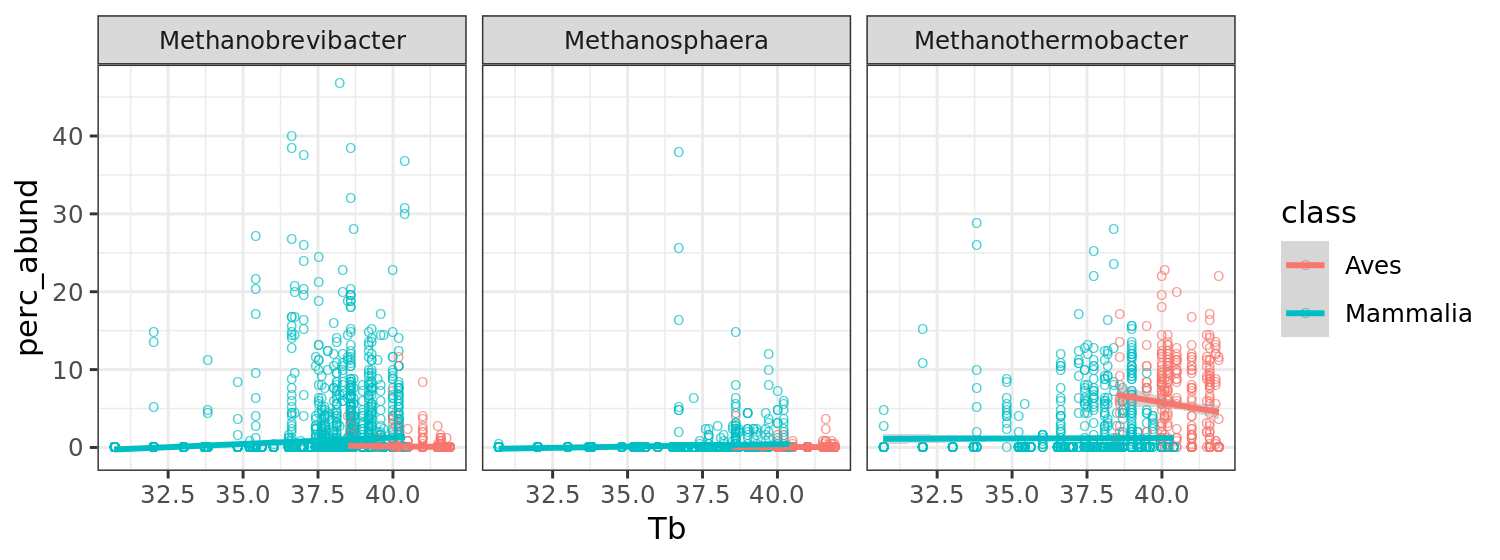

In [23]:
# plotting
p = otu_j %>%
    ggplot(aes(Tb, perc_abund, color=class)) +
    geom_point(alpha=0.7, shape='O') +
    geom_smooth(method='lm') +
    facet_wrap(~ Genus) +
    theme_bw()

p.dims(7.5,2.8)
plot(p)

`geom_smooth()` using formula 'y ~ x'



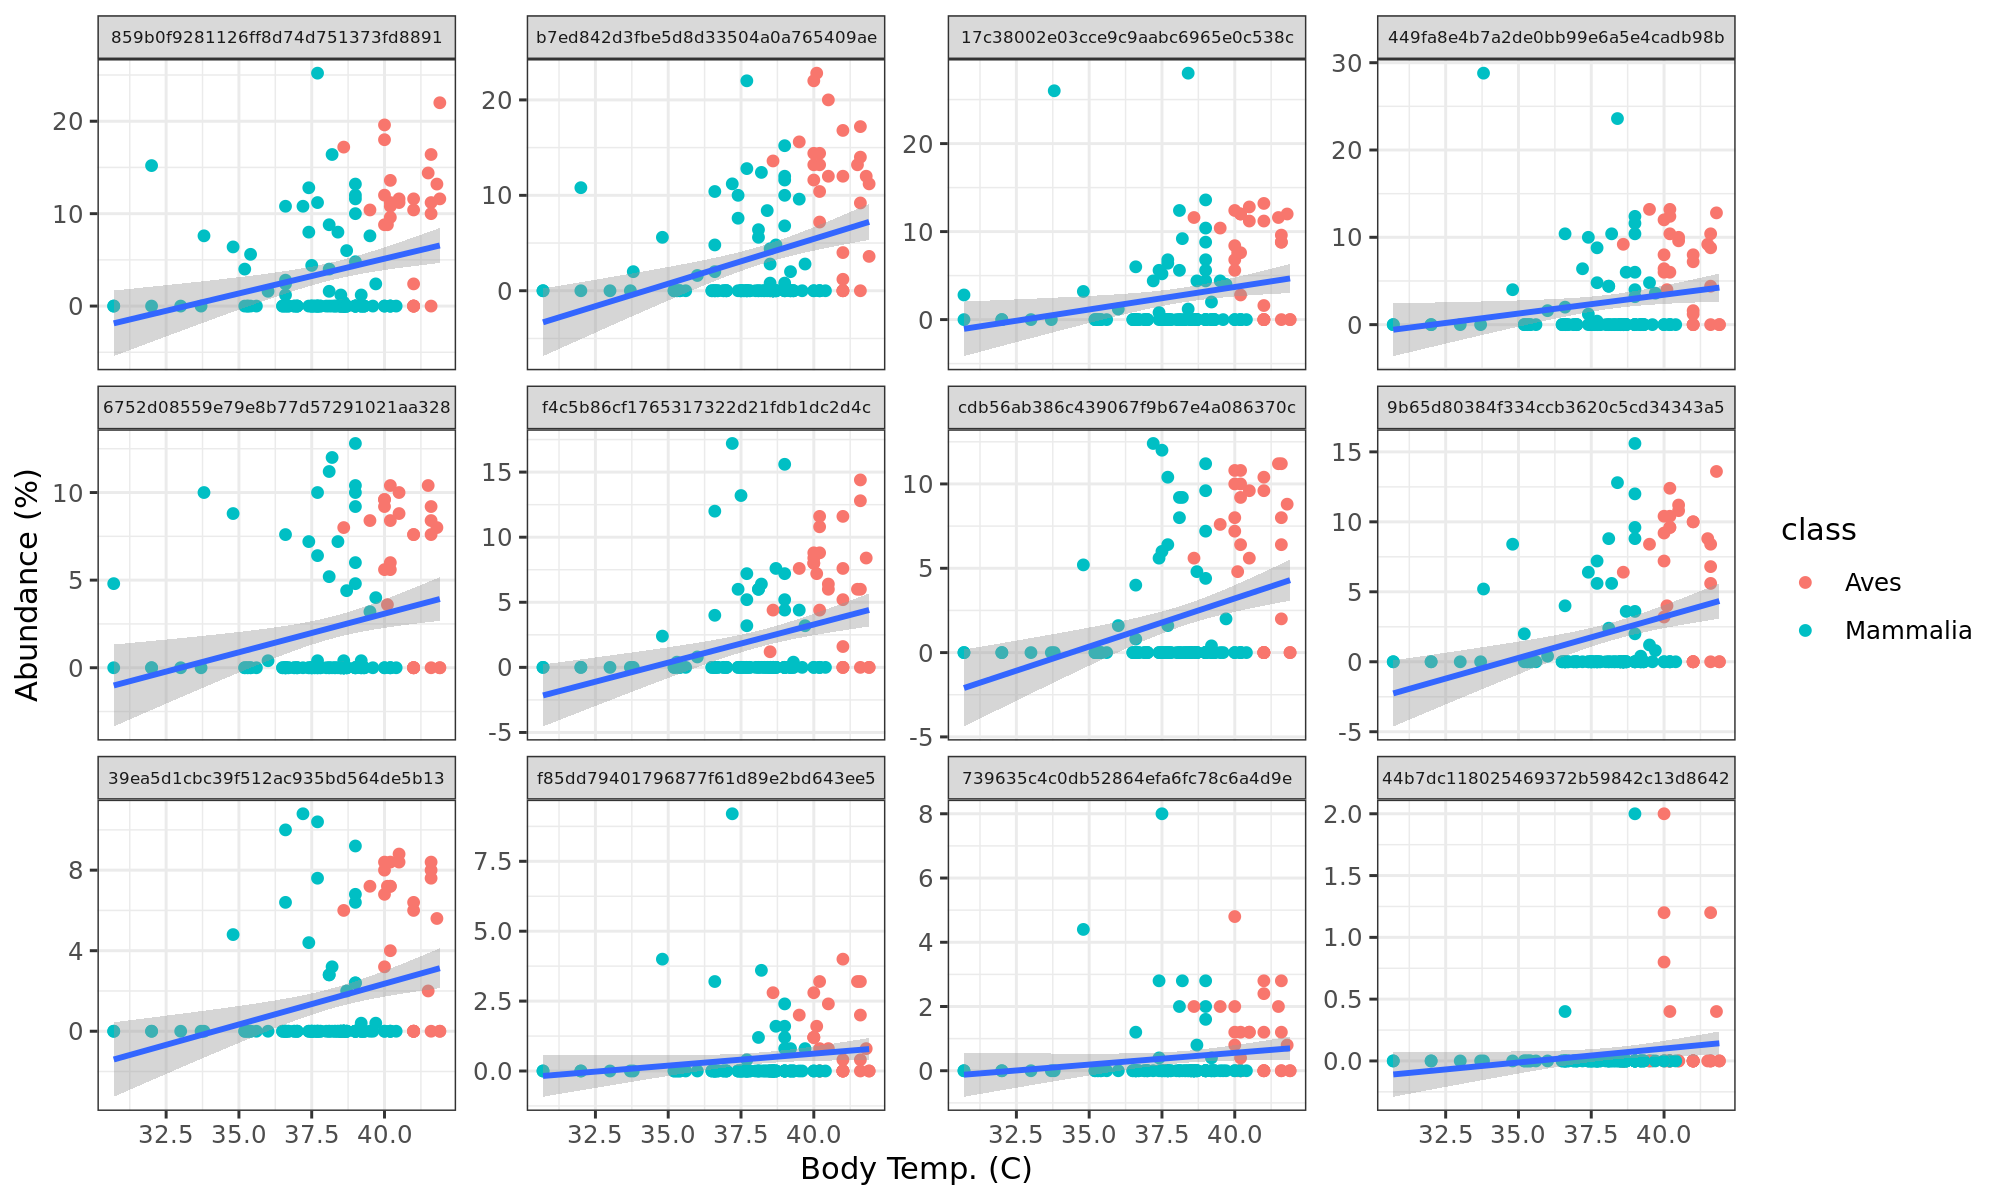

In [29]:
# plotting
p = otu_j %>%
    filter(Genus == 'Methanothermobacter') %>%
    mutate(OTU = gsub('X_', '', OTU)) %>%
    group_by(OTU) %>%
    mutate(mean_perc_abund = mean(perc_abund)) %>%
    ungroup() %>%
    mutate(OTU = OTU %>% reorder(-mean_perc_abund)) %>%
    ggplot(aes(Tb, perc_abund)) +
    geom_point(aes(color=class)) +
    geom_smooth(method='lm') +
    labs(x='Body Temp. (C)', y='Abundance (%)') +
    facet_wrap(~ OTU, scales='free_y') +
    theme_bw() +
    theme(
        strip.text = element_text(size=6)
    )

p.dims(10,6)
plot(p)

# Tree subsample

In [30]:
#' randomly selecting one per group
tree_subsample = function(L, df, tree){
    # get subsample (note: subsampling within each species)
    to_keep = df %>% 
        group_by(scientific_name) %>% 
        sample_n(1) %>%
        .$sample
    # subsampling tree
    to_rm = setdiff(tree$tip.label, to_keep)
    tree = drop.tip(tree, to_rm)
    return(tree)
}

In [31]:
# replicate analyses with different subsets of the host phylogeny
n_reps = 100

In [32]:
# permuted trees
df = metadata %>%
    mutate(sample = SampleID) %>%
    dplyr::select(sample, scientific_name) 

doParallel::registerDoParallel(threads)
host_tree_l = plyr::llply(as.list(1:n_reps), 
                          function(x) tree_subsample(x, df, host_tree),
                          .parallel=TRUE)
host_tree_l %>% length

[1] 100

In [33]:
# samples per permuted tree
host_tree_l %>% lapply(function(x) length(x$tip.label)) %>% as.numeric %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     72      72      72      72      72      72 

# RRPP

In [34]:
.rrpp_per = function(tree, taxon, otu, iter=999){
    # tree
    PhyCov = ape::vcv(tree, model = "Brownian")
    # otu
    otu_f = otu[rownames(PhyCov),]
    data = list(OTUs = otu_f[,taxon] %>% as.matrix,
                Tb = otu_f$Tb)
    names(data[['Tb']]) = rownames(otu_f)
    # rrpp
    fitGLS = lm.rrpp(OTUs ~ Tb, data = data, Cov = PhyCov,
                     print.progress = FALSE, SS.type = "II", iter = iter)
    anova(fitGLS)$table
}

rrpp_per = function(taxon, otu, trees, iter=999){
    df = trees %>% 
        plyr::llply(.rrpp_per, taxon=taxon, otu=otu, iter=iter, .parallel=FALSE) %>%
        do.call(rbind, .) %>%
        mutate(feature = gsub('[0-9]+$', '', rownames(.))) 
    df$taxon = taxon
    return(df)   
}

In [35]:
#running for all OTUs & all trees
taxa = colnames(otu)[2:ncol(otu)]
taxa %>% length %>% cat('Number of OTUs:', ., '\n')

doParallel::registerDoParallel(threads)
rrpp_res = taxa %>%
    plyr::llply(rrpp_per, otu, host_tree_l, iter=999, .parallel=TRUE) %>%
    do.call(rbind, .) %>%
    filter(feature == 'Tb')
rrpp_res

Number of OTUs: 62 


Df,SS,MS,Rsq,F,Z,Pr(>F),feature,taxon
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,2.50171787,2.50171787,0.13356956,10.7912524,1.6112091,0.003,Tb,X_9c1e5bb65fd0239bde43b74d3dc76e5c
1,0.03307558,0.03307558,0.00290976,0.2042776,-0.1300452,0.638,Tb,X_9c1e5bb65fd0239bde43b74d3dc76e5c
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,0.269730344,0.269730344,0.0123820301,0.877608687,0.4988556,0.376,Tb,b171d5cdecd235e7199d44ce8991794d
1,0.002343976,0.002343976,0.0001342216,0.009396776,-1.5031406,0.919,Tb,b171d5cdecd235e7199d44ce8991794d


## Summary

In [36]:
# formatting
rrpp_res_s = rrpp_res %>%
    rename('P' = `Pr(>F)`) %>%
    group_by(taxon) %>%
    mutate(P = (length(P) - sum(P < 0.05)) / length(P)) %>%
    ungroup() %>%
    mutate(Q = p.adjust(P, method='BH'))

rrpp_res_s %>% .$P %>% summary_x('P')
rrpp_res_s %>% .$Q %>% summary_x('Adj. P')
rrpp_res_s

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
P,0.25,0.73,0.99,0.858871,1,1,0.292,0.119


,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
Adj. P,1,1,1,1,1,1,0,0


Df,SS,MS,Rsq,F,Z,P,feature,taxon,Q
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,2.50171787,2.50171787,0.13356956,10.7912524,1.6112091,0.45,Tb,X_9c1e5bb65fd0239bde43b74d3dc76e5c,1
1,0.03307558,0.03307558,0.00290976,0.2042776,-0.1300452,0.45,Tb,X_9c1e5bb65fd0239bde43b74d3dc76e5c,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,0.269730344,0.269730344,0.0123820301,0.877608687,0.4988556,1,Tb,b171d5cdecd235e7199d44ce8991794d,1
1,0.002343976,0.002343976,0.0001342216,0.009396776,-1.5031406,1,Tb,b171d5cdecd235e7199d44ce8991794d,1


In [37]:
# significant taxa
tax = physeq %>%
    phyloseq2df(tax_table) %>%
    mutate(OTU = gsub('^([0-9])', 'X_\\1', OTU))

rrpp_res_s_f = rrpp_res_s %>%
    filter(Q < 0.05) %>%
    inner_join(tax, c('taxon'='OTU'))
rrpp_res_s_f

Df,SS,MS,Rsq,F,Z,P,feature,taxon,Q,Domain,Phylum,Class,Order,Family,Genus,Species
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>


# RRPP: no phy-cov

## RRPP

In [38]:
.rrpp_per = function(tree, taxon, otu, iter=999){
    # tree
    PhyCov = ape::vcv(tree, model = "Brownian")
    # otu
    otu_f = otu[rownames(PhyCov),]
    data = list(OTUs = otu_f[,taxon] %>% as.matrix,
                Tb = otu_f$Tb)
    names(data[['Tb']]) = rownames(otu_f)
    # rrpp
    fitGLS = lm.rrpp(OTUs ~ Tb, data = data, 
                     print.progress = FALSE, SS.type = "II", iter = iter)
    anova(fitGLS)$table
}

rrpp_per = function(taxon, otu, trees, iter=999){
    df = trees %>% 
        plyr::llply(.rrpp_per, taxon=taxon, otu=otu, iter=iter, .parallel=FALSE) %>%
        do.call(rbind, .) %>%
        mutate(feature = gsub('[0-9]+$', '', rownames(.))) 
    df$taxon = taxon
    return(df)   
}

In [39]:
#running for all OTUs & all trees
taxa = colnames(otu)[2:ncol(otu)]
taxa %>% length %>% cat('Number of OTUs:', ., '\n')

doParallel::registerDoParallel(threads)
rrpp_res = taxa %>%
    plyr::llply(rrpp_per, otu, host_tree_l, iter=999, .parallel=TRUE) %>%
    do.call(rbind, .) %>%
    filter(feature == 'Tb')
rrpp_res

Number of OTUs: 62 


Df,SS,MS,Rsq,F,Z,Pr(>F),feature,taxon
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,6.525389,6.525389,0.03086166,2.229110,NaN,0.147,Tb,X_9c1e5bb65fd0239bde43b74d3dc76e5c
1,2.677146,2.677146,0.01747814,1.245234,0.6526945,0.271,Tb,X_9c1e5bb65fd0239bde43b74d3dc76e5c
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,0.199488028,0.199488028,5.324161e-04,0.037288980,-0.8771456,0.8295,Tb,b171d5cdecd235e7199d44ce8991794d
1,0.008743533,0.008743533,2.520767e-05,0.001764581,-2.3263756,0.9695,Tb,b171d5cdecd235e7199d44ce8991794d


## Summary

In [40]:
# formatting
rrpp_res_s = rrpp_res %>%
    rename('P' = `Pr(>F)`) %>%
    group_by(taxon) %>%
    mutate(P = (length(P) - sum(P < 0.05)) / length(P)) %>%
    ungroup() %>%
    mutate(Q = p.adjust(P, method='BH'))

rrpp_res_s %>% .$P %>% summary_x('P')
rrpp_res_s %>% .$Q %>% summary_x('Adj. P')
rrpp_res_s

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
P,0,1,1,0.8593548,1,1,0.401,0.164


,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
Adj. P,0,1,1,0.8870968,1,1,0.402,0.164


Df,SS,MS,Rsq,F,Z,P,feature,taxon,Q
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,6.525389,6.525389,0.03086166,2.229110,NaN,1,Tb,X_9c1e5bb65fd0239bde43b74d3dc76e5c,1
1,2.677146,2.677146,0.01747814,1.245234,0.6526945,1,Tb,X_9c1e5bb65fd0239bde43b74d3dc76e5c,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,0.199488028,0.199488028,5.324161e-04,0.037288980,-0.8771456,1,Tb,b171d5cdecd235e7199d44ce8991794d,1
1,0.008743533,0.008743533,2.520767e-05,0.001764581,-2.3263756,1,Tb,b171d5cdecd235e7199d44ce8991794d,1


In [41]:
# significant taxa
tax = physeq %>%
    phyloseq2df(tax_table) %>%
    mutate(OTU = gsub('^([0-9])', 'X_\\1', OTU))

rrpp_res_s_f = rrpp_res_s %>%
    filter(Q < 0.05) %>%
    inner_join(tax, c('taxon'='OTU'))
rrpp_res_s_f

Df,SS,MS,Rsq,F,Z,P,feature,taxon,Q,Domain,Phylum,Class,Order,Family,Genus,Species
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,151.7898,151.7898,0.1164318,9.224216,1.640962,0,Tb,X_9b65d80384f334ccb3620c5cd34343a5,0,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanothermobacteraceae,Methanothermobacter,Methanothermobacter marburgensis str. Marburg
1,195.2239,195.2239,0.1498589,12.339275,1.668089,0,Tb,X_9b65d80384f334ccb3620c5cd34343a5,0,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanothermobacteraceae,Methanothermobacter,Methanothermobacter marburgensis str. Marburg
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,88.77921,88.77921,0.1126567,8.887165,1.608930,0,Tb,X_39ea5d1cbc39f512ac935bd564de5b13,0,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanothermobacteraceae,Methanothermobacter,unclassified
1,94.97685,94.97685,0.1143678,9.039582,1.537478,0,Tb,X_39ea5d1cbc39f512ac935bd564de5b13,0,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanothermobacteraceae,Methanothermobacter,unclassified


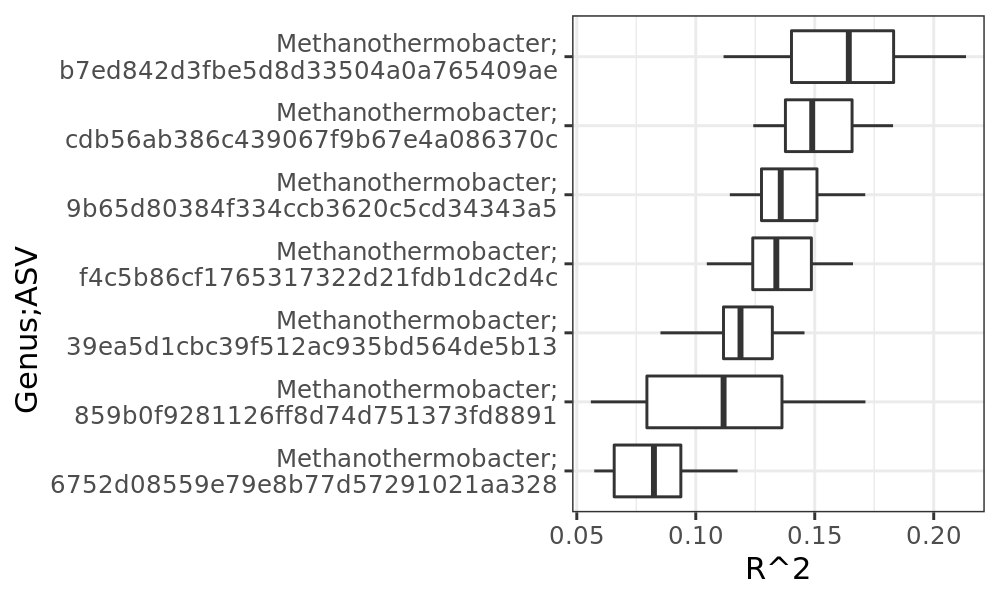

In [43]:
# plotting
p = rrpp_res_s_f %>%
    mutate(taxon = gsub('^X_', '', taxon)) %>%
    mutate(Taxonomy = paste(Genus, taxon, sep='; '),
           Genus = gsub(' ', '\n', Genus),
           Taxonomy = stringr::str_wrap(Taxonomy, 20)) %>%
    group_by(Taxonomy) %>%
    mutate(mean_Rsq = median(Rsq)) %>%
    ungroup() %>%
    mutate(Taxonomy = Taxonomy %>% reorder(mean_Rsq)) %>%
    ggplot(aes(Taxonomy, Rsq)) +
    geom_boxplot() +
    labs(x='Genus;ASV', y='R^2') +
    theme_bw() +
    theme(
        axis.title.y = element_text(hjust = 0.3)
    ) +
    coord_flip()

p.dims(5,3)
plot(p)

# sessionInfo

In [44]:
sessionInfo()

R version 4.0.0 (2020-04-24)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects/Georg_animal_feces/envs/phyloseq-physig/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] LeyLabRMisc_0.1.6 doParallel_1.0.15 iterators_1.0.12  foreach_1.5.0    
 [5] RRPP_0.6.0        phyloseq_1.32.0   ape_5.4           ggplot2_3.3.1    
 [9] tidyr_1.1.0       dplyr_1.0.0      

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.4.6      